# Image Detection - Car Damage Detector


In the following Notebook, we're going to build an Image Classifier which can detect whether the image of a car exhibits damage or not. 

In order to acheive this, we're going to use a combination of a pre-trained Model and Transfer learning to learn from a new dataset of cars. The new dataset will contain cars with and without damage. The Orginal Dataset can be found here: 

https://storage.googleapis.com/kaggle-data-sets/278578/575693/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1580452098&Signature=PAEfJV9YaDrFvPgisbNL8eLIyJb6GQSp0jjIVGPxE6pn4mIh%2FZa9KBiSdCWZdqcDl5vp4p9k2Vtfu7BH30%2Br4HQfu4OO0bTNAjsrK6bxhvzNOdv%2BrEtDCHciHv


An additional set of resources which have been helpful in this example can be found here:

http://ai.stanford.edu/~jkrause/cars/car_dataset.html


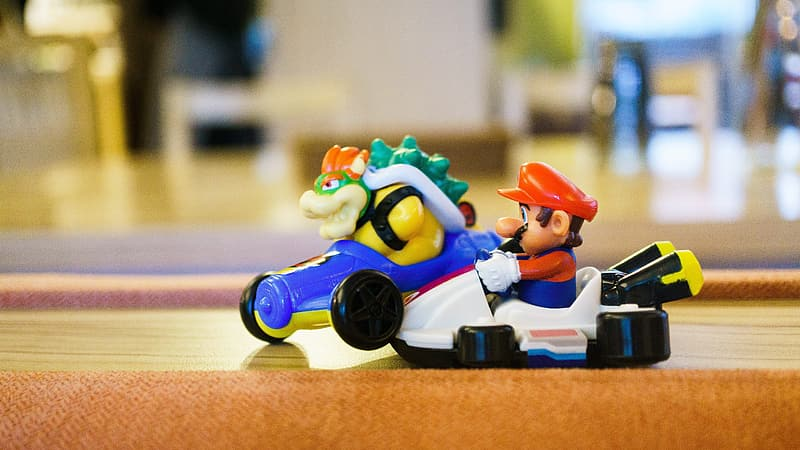


### General Imports

These are the libraries which we will require in order to complete different types of operations

In [3]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report


## Part 1. Car Damage Detector

In part 1, we're going to download our data, structure it, and use it to train a pre-trained image classification algorithm to detect damage on a car

### Constant Set-up
Configure all global constants here, these are variables which will remain constant throughout the execution of the notebook.

In [16]:

# NOTE: S3 bucket name must begin with "deeplens-" for DeepLens deployment
bucket_name='dataset-cars-damage'
prefix = '' #only use this if you want to have your files in a folder 
dataset_filename = 'car-damage-dataset.zip'
dataset_unpacked_dir = 'car-damage-dataset/'

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [17]:
def setup_env():
    
    role = get_execution_role()

    sess = sagemaker.Session()

    
    AWS_REGION = 'us-east-1'
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(bucket_name)

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
    return role, sess, AWS_REGION, s3,s3_bucket

role, sess,  AWS_REGION, s3, s3_bucket = setup_env()

Bucket already exists


### Download Data and Create Manifest

Here we are goin to download the data to our bucket if it does not already exist. This dataset is a pre-compiled dataset of car images which contain 2 typers:

- Whole (e.g. without damage)
- Damaged (e.g. those with damage)

The following create_dataset method will first download the Zip of the data, and then unpack it to the bucket named in the global constants



In [4]:
def create_dataset(bucket_name, s3_bucket):
    
    dataset_key = 'car-damage-dataset.zip'
    objs = list(s3_bucket.objects.filter(Prefix=dataset_key))
    if len(objs) > 0 and objs[0].key == dataset_key:
        exists = True
        print('{} Already Exists'.format(dataset_key) )
    else:
        exists = False
    
    if not exists:
    
        bucket = bucket_name
        #copy first

        source= { 'Bucket' : 'public-datasets', 'Key': dataset_key}
        s3_bucket.copy(source, dataset_key)


        s3 = boto3.client('s3', use_ssl=False)
        Key_unzip = dataset_unpacked_dir

    
        s3_resource = boto3.resource('s3')
        #Now create zip object one by one, this below is for 1st file in file_list
        zip_obj = s3_resource.Object(bucket_name=bucket_name, key=dataset_key)
        print('Unpacking {}\n'.format(dataset_key))
        
        print (zip_obj)
        buffer = BytesIO(zip_obj.get()["Body"].read())
        z = zipfile.ZipFile(buffer)
        for filename in z.namelist():
            file_info = z.getinfo(filename)
            s3_resource.meta.client.upload_fileobj(
                z.open(filename),
                Bucket=bucket_name,
                Key=Key_unzip + f'{filename}')
            
        
    
create_dataset(bucket_name, s3_bucket)

car-damage-dataset.zip Already Exists


### Create the Dataset Manifest

The manifest file will comprise of a tab separated file, which contains an index (unique for all). the class, and the path to the file (s3 bucket location)

A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column should be unique across all of the images. Here we make an image list file using the im2rec tool from MXNet. You can also create the .lst file in your own way. An example of .lst file is shown as follows:

01    1.0    filea.jpg <br>
02    2.0    fileb.jpg

When you are bringing your own image files to train, please ensure that the .lst file follows the same format as described above. In order to train with the lst format interface, passing the lst file for both training and validation in the appropriate format is mandatory. Once we have the data available in the correct format for training, the next step is to upload the image and .lst file to S3 bucket.


In [18]:
def create_dataset_manifest(bucket_name, s3, data_path):
    
    manifest_train = []
    manifest_val = []
    
    idx = 0
    conn = boto3.client('s3')  # again assumes boto.cfg setup, assume AWS S3
    
    for file in s3.objects.all():#(Bucket=bucket_name, Prefix=data_path)['Contents']:
        path = file.key
#         print(path)
        if ('.JPEG' in path) or ('.jpeg' in path):
            if 'training' in path:
                man = {}
                relative_path = path.replace('training/','')
#                 print(relative_path)
                if 'damage' in path:
                    data_class = 1.0
                else:
                    data_class = 0.0
                man = {'idx':idx, 'class': data_class, 'path':relative_path, 'path_with_prefix':path}
                manifest_train.append(man)
                
            if 'validation' in path:
                man = {}
                relative_path = path.replace('validation/','')
                if 'damage' in path:
                    data_class = 1.0
                else:
                    data_class = 0.0
                man = {'idx':idx, 'class': data_class, 'path':relative_path, 'path_with_prefix':path}
                manifest_val.append(man)
            idx += 1
    print('Training Dataset Size {}, Validation Size {}'.format(len(manifest_train), len(manifest_val)))
    
    ##Create Augmented JSON Record file
    aug_train = []
    for x in manifest_train:
        absolute_path = 's3://{}/{}'.format(bucket_name, x['path_with_prefix'])
        
        dic = {'source-ref':absolute_path, 'class': str(x['class'])}
        aug_train.append(dic)

    with open('train_manifest.json', 'w') as fout:
        for x in aug_train:
            fout.write(json.dumps(x)+'\n')
            #json.dump(aug_train, fout, indent=4)
    
    val_train = []
    for x in manifest_val:
        absolute_path = 's3://{}/{}'.format(bucket_name, x['path_with_prefix'])
        
        dic = {'source-ref':absolute_path, 'class': str(x['class'])}
        val_train.append(dic)

    with open('val_manifest.json', 'w') as fout:
         for x in val_train:
            fout.write(json.dumps(x)+'\n')

    return manifest_train, manifest_val 
            
manifest_train, manifest_val  = create_dataset_manifest(bucket_name, s3_bucket, '')   
    

Training Dataset Size 105434, Validation Size 26361


In [19]:
def upload_metadata(s3_bucket):
    
    train_file_s3 = 'train_lst/train_manifest.json'
    s3_bucket.upload_file('./train_manifest.json', train_file_s3)
    val_file_s3 = 'val_lst/val_manifest.json'
    s3_bucket.upload_file('./val_manifest.json', val_file_s3)
    
    
upload_metadata(s3_bucket)


## Configure Classifier

We will be using a pre-trained classifier in order to kick off the training process. A pretrained model allows us to take a model which has already been trained on million's of images, and then use a method known as transfer learning to fine tune the model to predict the specific set of classes which we will use for our detection task.

In [9]:
def setup_classifier():

    training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
    print (training_image)
    return training_image

training_image = setup_classifier()

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest


### Fine-tuning the Image Classification Model
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a sageMaker.estimator.Estimator object. This estimator will launch the training job.

### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

- Training instance count: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings.
- Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training
- Output path: This the s3 folder in which the training output is stored

In [10]:
def configure_estimator(bucket_name, sess, training_image):

    s3_output_location = 's3://{}/output'.format(bucket_name)
    ic = sagemaker.estimator.Estimator(training_image,
                                             role, 
                                             train_instance_count=4, 
                                             train_instance_type='ml.p3.16xlarge',
                                             train_volume_size = 50,
                                             train_max_run = 360000,
                                             input_mode= 'Pipe',
                                             output_path=s3_output_location,
                                             sagemaker_session=sess)
    return ic

ic = configure_estimator(bucket_name, sess, training_image)

### Hyperparameter Tuning

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

- **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
use_pretrained_model: Set to 1 to use pretrained model for transfer learning.
- **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
- **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
- **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
- **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
- **epochs**: Number of training epochs.
- **learning_rate**: Learning rate for training.
- **top_k**: Report the top-k accuracy during training.
- **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
- **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode

In [12]:
def configure_hyperparams(ic):
    ic.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,150,250",
                             num_classes=2,
                             mini_batch_size=32,
                             epochs=10,
                             learning_rate=0.001,
                             top_k=1,
                             num_training_samples=105434,
                             precision_dtype='float32')
    
    return ic

ic = configure_hyperparams(ic)

### Configure Data Sources

Based on the data we've created in the s3 bucket, and the manifests associated with these image files, we need to structure this into an object which then is passed to the Estimator.

In [13]:
def configure_data_channels(bucket_name):
    
    s3train = 's3://{}/training'.format(bucket_name)
    s3validation = 's3://{}/validation'.format(bucket_name)
    s3train_lst = 's3://{}/train_lst/'.format(bucket_name)
    s3validation_lst = 's3://{}/val_lst/'.format(bucket_name)
    s3train_manifest = 's3://{}/train_lst/{}'.format(bucket_name,'train_manifest.json')
    s3validation_manifest = 's3://{}/val_lst/{}'.format(bucket_name,'val_manifest.json')
    print(s3train_lst)
    
    attribute_names = ["source-ref","class"]

    
    train_data = sagemaker.session.s3_input(s3train_manifest, 
                                            distribution='FullyReplicated', 
                                            content_type='application/x-image', 
                                            s3_data_type='AugmentedManifestFile',
                                            attribute_names=attribute_names,
                                            record_wrapping='RecordIO')
    
    validation_data = sagemaker.session.s3_input(s3validation_manifest, 
                                                 distribution='FullyReplicated', 
                                                 content_type='application/x-image', 
                                                 s3_data_type='AugmentedManifestFile',
                                                 attribute_names=attribute_names,
                                                 record_wrapping='RecordIO')
    
#     train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
#                             content_type='application/x-image', s3_data_type='S3Prefix', record_wrapping='RecordIO')
    
#     validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
#                                  content_type='application/x-image', s3_data_type='S3Prefix',record_wrapping='RecordIO')

    data_channels = {'train': train_data, 'validation': validation_data}#
#                      'train_lst': train_data_lst, 'validation_lst': validation_data_lst}
    
    
    return data_channels

data_channels = configure_data_channels(bucket_name)

s3://dataset-cars-damage/train_lst/


## Train the model

In [ ]:
def train_model(ic):
    ic.fit(inputs=data_channels, logs=True)
    return ic

ic = train_model(ic)

2020-02-28 06:52:00 Starting - Starting the training job...
2020-02-28 06:52:02 Starting - Launching requested ML instances.........
2020-02-28 06:53:40 Starting - Preparing the instances for training.........
2020-02-28 06:55:16 Downloading - Downloading input data
2020-02-28 06:55:16 Training - Downloading the training image...
2020-02-28 06:55:51 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[02/28/2020 06:55:53 INFO 140090475472704] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype

[02/28/2020 06:55:57 INFO 139754190743360] Setting number of threads: 63
[02/28/2020 06:55:57 INFO 139977791772480] Setting number of threads: 63
[02/28/2020 06:55:57 INFO 140090475472704] Setting number of threads: 63
[06:56:34] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1.x.1888.0/AL2012/generic-flavor/src/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[06:56:34] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1.x.1888.0/AL2012/generic-flavor/src/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[06:56:34] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1

[02/28/2020 06:56:59 INFO 139754190743360] Epoch[0] Batch [280]#011Speed: 307.665 samples/sec#011accuracy=0.999333
[02/28/2020 06:57:00 INFO 139754190743360] Epoch[0] Batch [300]#011Speed: 313.068 samples/sec#011accuracy=0.999377
[02/28/2020 06:57:00 INFO 139977791772480] Epoch[0] Batch [300]#011Speed: 313.148 samples/sec#011accuracy=0.999169
[02/28/2020 06:57:00 INFO 140090475472704] Epoch[0] Batch [300]#011Speed: 312.939 samples/sec#011accuracy=0.998858
[02/28/2020 06:57:02 INFO 139977791772480] Epoch[0] Batch [320]#011Speed: 317.764 samples/sec#011accuracy=0.999221
[02/28/2020 06:57:02 INFO 140090475472704] Epoch[0] Batch [320]#011Speed: 317.570 samples/sec#011accuracy=0.998929
[02/28/2020 06:57:02 INFO 139754190743360] Epoch[0] Batch [320]#011Speed: 317.747 samples/sec#011accuracy=0.999416
[02/28/2020 06:57:02 INFO 140442406074176] Epoch[0] Batch [320]#011Speed: 318.157 samples/sec#011accuracy=0.999221
[02/28/2020 06:57:03 INFO 139754190743360] Epoch[0] Batch [340]#011Speed: 322.26

[02/28/2020 06:57:29 INFO 139977791772480] Epoch[0] Batch [620]#011Speed: 330.945 samples/sec#011accuracy=0.999597
[02/28/2020 06:57:29 INFO 140090475472704] Epoch[0] Batch [620]#011Speed: 330.829 samples/sec#011accuracy=0.999446
[02/28/2020 06:57:31 INFO 139977791772480] Epoch[0] Batch [640]#011Speed: 333.067 samples/sec#011accuracy=0.999610
[02/28/2020 06:57:31 INFO 140090475472704] Epoch[0] Batch [640]#011Speed: 332.895 samples/sec#011accuracy=0.999464
[02/28/2020 06:57:33 INFO 139977791772480] Epoch[0] Batch [660]#011Speed: 335.073 samples/sec#011accuracy=0.999622
[02/28/2020 06:57:33 INFO 140090475472704] Epoch[0] Batch [660]#011Speed: 334.970 samples/sec#011accuracy=0.999480
[02/28/2020 06:57:33 INFO 139754190743360] Epoch[0] Batch [660]#011Speed: 335.068 samples/sec#011accuracy=0.999716
[02/28/2020 06:57:34 INFO 140090475472704] Epoch[0] Batch [680]#011Speed: 336.892 samples/sec#011accuracy=0.999495
[02/28/2020 06:57:34 INFO 139754190743360] Epoch[0] Batch [680]#011Speed: 336.96

[02/28/2020 06:59:05 INFO 139754190743360] Epoch[1] Batch [200]#011Speed: 276.918 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:05 INFO 140442406074176] Epoch[1] Batch [200]#011Speed: 276.868 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:05 INFO 139977791772480] Epoch[1] Batch [200]#011Speed: 276.868 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:05 INFO 140090475472704] Epoch[1] Batch [200]#011Speed: 276.965 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:07 INFO 139977791772480] Epoch[1] Batch [220]#011Speed: 285.496 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:07 INFO 140090475472704] Epoch[1] Batch [220]#011Speed: 285.337 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:07 INFO 139754190743360] Epoch[1] Batch [220]#011Speed: 285.436 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:07 INFO 140442406074176] Epoch[1] Batch [220]#011Speed: 285.344 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:08 INFO 139754190743360] Epoch[1] Batch [240]#011Speed: 292.99

[02/28/2020 06:59:35 INFO 139754190743360] Epoch[1] Batch [560]#011Speed: 342.113 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:36 INFO 139754190743360] Epoch[1] Batch [580]#011Speed: 343.840 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:36 INFO 140442406074176] Epoch[1] Batch [580]#011Speed: 343.792 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:36 INFO 139977791772480] Epoch[1] Batch [580]#011Speed: 343.811 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:36 INFO 140090475472704] Epoch[1] Batch [580]#011Speed: 343.848 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:38 INFO 139977791772480] Epoch[1] Batch [600]#011Speed: 345.581 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:38 INFO 140090475472704] Epoch[1] Batch [600]#011Speed: 345.571 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:38 INFO 139754190743360] Epoch[1] Batch [600]#011Speed: 345.560 samples/sec#011accuracy=1.000000
[02/28/2020 06:59:38 INFO 140442406074176] Epoch[1] Batch [600]#011Speed: 345.57

[02/28/2020 07:01:11 INFO 140090475472704] Epoch[2] Batch [140]#011Speed: 265.424 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:12 INFO 140090475472704] Epoch[2] Batch [160]#011Speed: 277.746 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:12 INFO 139977791772480] Epoch[2] Batch [160]#011Speed: 277.828 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:14 INFO 139977791772480] Epoch[2] Batch [180]#011Speed: 288.069 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:14 INFO 140090475472704] Epoch[2] Batch [180]#011Speed: 288.108 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:15 INFO 139977791772480] Epoch[2] Batch [200]#011Speed: 297.109 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:15 INFO 140090475472704] Epoch[2] Batch [200]#011Speed: 297.072 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:17 INFO 139977791772480] Epoch[2] Batch [220]#011Speed: 304.504 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:17 INFO 140090475472704] Epoch[2] Batch [220]#011Speed: 304.56

[02/28/2020 07:01:46 INFO 139977791772480] Epoch[2] Batch [600]#011Speed: 364.055 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:48 INFO 139977791772480] Epoch[2] Batch [620]#011Speed: 365.099 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:50 INFO 139977791772480] Epoch[2] Batch [640]#011Speed: 366.371 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:50 INFO 140090475472704] Epoch[2] Batch [640]#011Speed: 366.328 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:51 INFO 139977791772480] Epoch[2] Batch [660]#011Speed: 367.757 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:51 INFO 140090475472704] Epoch[2] Batch [660]#011Speed: 367.765 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:51 INFO 139754190743360] Epoch[2] Batch [660]#011Speed: 367.783 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:51 INFO 140442406074176] Epoch[2] Batch [660]#011Speed: 367.823 samples/sec#011accuracy=1.000000
[02/28/2020 07:01:53 INFO 140442406074176] Epoch[2] Batch [680]#011Speed: 368.89

## Deploy the Endpoint

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the ml.p3.2xlarge instance to train, but we choose to host the model on the less expensive cpu instance, ml.m4.xlarge. The endpoint deployment can be accomplished as follows:



In [15]:
ic_classifier = ic.deploy(initial_instance_count = 1,
                          instance_type = 'ml.m4.xlarge')

-----------------!

### Inferencing - Test the Classifier

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference.

In [22]:
manifest_val

[{'idx': 105434,
  'class': 1.0,
  'path': 'augmented/damage-val-0001-augmented-0.JPEG',
  'path_with_prefix': 'validation/augmented/damage-val-0001-augmented-0.JPEG'},
 {'idx': 105435,
  'class': 1.0,
  'path': 'augmented/damage-val-0001-augmented-1.JPEG',
  'path_with_prefix': 'validation/augmented/damage-val-0001-augmented-1.JPEG'},
 {'idx': 105436,
  'class': 1.0,
  'path': 'augmented/damage-val-0001-augmented-10.JPEG',
  'path_with_prefix': 'validation/augmented/damage-val-0001-augmented-10.JPEG'},
 {'idx': 105437,
  'class': 1.0,
  'path': 'augmented/damage-val-0001-augmented-11.JPEG',
  'path_with_prefix': 'validation/augmented/damage-val-0001-augmented-11.JPEG'},
 {'idx': 105438,
  'class': 1.0,
  'path': 'augmented/damage-val-0001-augmented-12.JPEG',
  'path_with_prefix': 'validation/augmented/damage-val-0001-augmented-12.JPEG'},
 {'idx': 105439,
  'class': 1.0,
  'path': 'augmented/damage-val-0001-augmented-13.JPEG',
  'path_with_prefix': 'validation/augmented/damage-val-0001

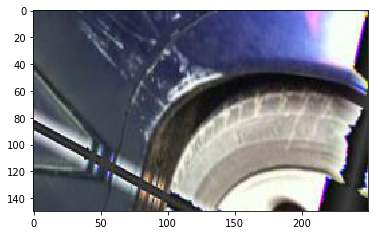

In [27]:
def display_test_img(bucket_name, test_manifest):
    
    test_count = len(test_manifest)
    random_annotation = test_manifest[random.randint(0,test_count-1)]
    s3_uri = random_annotation['path']
    if 'train' in s3_uri:
        root = 'training/'
    else:
        root = 'validation/'
    if 'augmented' in s3_uri:
        root = root + 'augmented/'
    s3_key = os.path.basename(s3_uri)
    local_path = 'images/' + s3_key
#     print(s3_key)
    s3.Bucket(bucket_name).download_file(root+s3_key, local_path)  
    
    raw_img = mpimg.imread(local_path)
    plt.imshow(raw_img)
    return s3_key, local_path

s3_key,local_path = display_test_img(bucket_name, manifest_val)
# print(s3_key)

Image Name damage-val-0007-augmented-62.JPEG
Result: label - Damage, probability - 0.9999428987503052


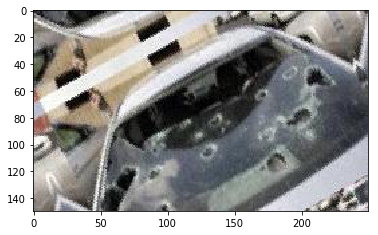

In [29]:
def test_predictor(bucket_name, test_manifest):
    
    s3_key, local_path = display_test_img(bucket_name, test_manifest)

    with open(local_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    
    ic_classifier.content_type = 'application/x-image'
    result = json.loads(ic_classifier.predict(payload))
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    object_categories = ['No Damage','Damage']
    print('Image Name {}'.format(s3_key))
    print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
    
test_predictor(bucket_name, manifest_val)

In [20]:
def retrieve_single_image(bucket_name, manifest_entry):
    
    root = 'testing/'
    s3_uri = manifest_entry['path']
    if 'train' in s3_uri:
        root = 'training/'
    else:
        root = 'validation/'
    if 'augmented' in s3_uri:
        root = root + 'augmented/'
    
    s3_key = os.path.basename(s3_uri)
    local_path = 'images/' + s3_key
    s3.Bucket(bucket_name).download_file(root+s3_key, local_path)  
    
    raw_img = mpimg.imread(local_path)
    return s3_key, local_path

In [21]:
def predict_single_image_and_return_score_label(ic_classifier,s3_key, local_path):
    '''
    Returns: actual_label, predicted_label, confidence_score
    '''
    with open(local_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    
    ic_classifier.content_type = 'application/x-image'

    result = json.loads(ic_classifier.predict(payload))
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    object_categories = ['No Damage','Damage']
    if 'whole' in s3_key:
        actual_label = 'No Damage'
    else:
        actual_label = 'Damage'
#     print('Image Name {}'.format(s3_key))
#     print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
    return actual_label, object_categories[index], result[index]

### Precision Recall Testing

Once we've deployed our model, it's important to ensure that the predictions being made are accurate and useful for a production system. Precision / Recall testing is a traditional method for testing the model's ability to predict accurately, and how well the model finds the correct classes, amongst the entire dataset. Below is the formula used to evaluate the precision and recall of a model. 

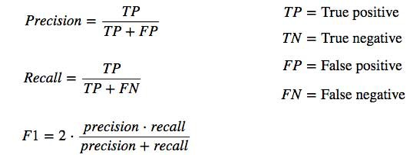

PR is a useful model performance measure/metric for a classification task, however, in more complex prediction scenarions, such as boundary boxes for object detection and image segmentation, other metrics such as Average Precision (AP), is used as a measure, which combines both Precision and Recall, plus Intersection over Union (IoU), which measures the accuracy of a model based on the region within the image it predicts is a specific class.

In [48]:
# os.chdir('Car-Damage-Detector/')
# print(os.getcwd())

def calculate_model_performance(ic_classifer, bucket_name, manifest, printoutput = False):

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    df = pd.DataFrame(columns = ['actual_label','predicted_label','confidence_score'])
    #iterate through all images and predict their class...
    max_inferences = 200
    cnt = 0
    manifest_len = len(manifest)
    for i in range(0, max_inferences) :
            
        entry = manifest[random.randint(0,manifest_len-1)]
        
        s3_key, local_path = retrieve_single_image(bucket_name, entry)
        actual_label, predicted_label, confidence_score = predict_single_image_and_return_score_label(ic_classifer, s3_key, local_path)
#         print(actual_label)

        df.loc[len(df)]=[actual_label, predicted_label, confidence_score] 
        os.remove(local_path)
        cnt +=1
        if cnt >= max_inferences:
            break
    #now we have all the data in the dataframe...
#     print(df)
    pos_class= 'Damage'
    neg_class = 'No Damage'
    for idx,row in df.iterrows():
        if row['actual_label'] == row['predicted_label']:
            
            if row['actual_label'] == pos_class:
                tp += 1
            else:
                tn += 1
        else:
            if row['actual_label'] == pos_class:
                fn += 1
            else:
                fp += 1
            
    
    positive_classes = df['actual_label'][df.actual_label == pos_class].count()
    negative_classes = df['actual_label'][df.actual_label == neg_class].count()
    
    class_report = classification_report(df['actual_label'], df['predicted_label'])
    
    if printoutput:
        print('Positive Records {}, Negative Records {}'.format(positive_classes, negative_classes))
        print('Detection Results (Absolute):')
        print('True Positive {}'.format(tp))
        print('True Negative {}'.format(tn))
        print('False Positive {}'.format(fp))
        print('False Negative {}'.format(fn))

        #And use Classification Report from Skit-Learn
        target_names = ['Positive', 'Negative']
        print(class_report)#, target_names=target_names))
        
    return class_report, tp, tn, fp, fn

              
    
lass_report = calculate_model_performance(cdd.predictor, bucket_name, manifest_val, printoutput = True)


Positive Records 173, Negative Records 27
Detection Results (Absolute):
True Positive 173
True Negative 0
False Positive 27
False Negative 0
              precision    recall  f1-score   support

      Damage       0.86      1.00      0.93       173
   No Damage       0.00      0.00      0.00        27

   micro avg       0.86      0.86      0.86       200
   macro avg       0.43      0.50      0.46       200
weighted avg       0.75      0.86      0.80       200



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---


## Part 2. Object Detector - Pre-Trained

In Part 2, we're going to demonstrate the use of a pre-trained model for object detection.

The following code demonstrates the use of a Object-Detection Model, which has been pretrained on a subset of the COCO 2017 Dataset, for more information please visit: http://cocodataset.org/#home

To examine how this model was developed, please check out the following [notebook](Car-Detector/object_detection_image_json_format.ipynb)

In [261]:
from objectdetector import ObjectDetector

In [ ]:
#Create a new ObjectDetector Object, and specify the endpoint name (this is name that is visbile in the AWS Console)
od = ObjectDetector('object-detection-2020-01-30-07-10-53-209')

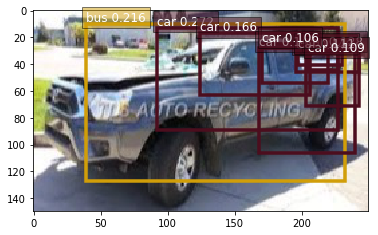

{'car': 0.10639837384223938, 'bus': 0.2156228870153427}

In [258]:
od.visualize_detection(bucket_name, manifest_train, thresh=0.1)

---

## Part 3. Demonstration of Both Models Working Together

In the following example, we're going to show what happens if we use both models to support an example where we need to determine whether first, the image contains a car, and second, whether the car is damaged or not. The justification of why we have separate models is based on needing specific classifiers trained for different purposes.

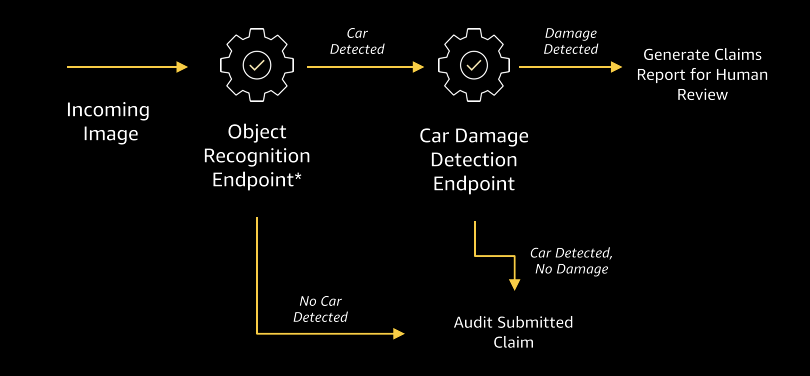

In [12]:
os.chdir('../src/')
print(os.getcwd())
from objectdetector import ObjectDetector
from cardamagedetector import CarDamageDetector

/home/ec2-user/SageMaker/Car-Damage-Detector/src


In [15]:
# od = ObjectDetector('object-detection-2020-01-30-07-10-53-209')
cdd = CarDamageDetector('image-classification-2020-02-28-06-52-00-232')

Instantiating Car Damage Detector
Adding Class Labels
Added 2 Class Labels


In [77]:
def determine_if_needs_audit_or_filing(od, cdd, image_url, acceptable_thresh = 0.1):
    
    obj_to_detect = 'car'
    expected_predicted_class = 'Damage'
    #download the image
    image_local_path = od.download_image(image_url, to_save_filename='test-image.jpg')
    #score the image with the first model
    classes_and_scores = od.visualize_detection(image_local_path, acceptable_thresh)
    print(classes_and_scores)
    #1. first run it through the obhect detector

    goto_second_classifier = False
    #Determine if a car exists in the object
    if obj_to_detect in classes_and_scores:
        if classes_and_scores[obj_to_detect] > acceptable_thresh:
            goto_second_classifier = True
    
    if goto_second_classifier:    
    #2. Now check if the image contains a damaged vehicle
        predicted_class = cdd.predict_if_contains_damage(image_local_path)
        if expected_predicted_class == 'Damage':
            print('No Audit Needed, execute workflow to create report')
        else:
            print('Audit Required')
        

downloading Image from https://image.shutterstock.com/z/stock-photo-isolate-side-of-the-car-the-color-of-braun-white-which-crashed-with-another-car-until-it-was-596238068.jpg
Saved Image to test-image.jpg


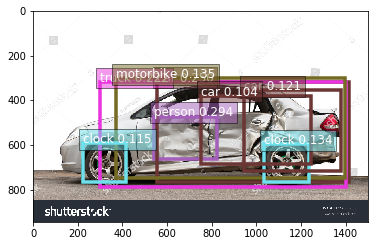

{'person': 0.2944055199623108, 'car': 0.10353279113769531, 'truck': 0.2221212089061737, 'motorbike': 0.13522975146770477, 'clock': 0.11485514044761658}
Image Name test-image.jpg
Result: label - Damage, probability - 0.9999637603759766
No Audit Needed, execute workflow to create report


In [78]:
determine_if_needs_audit_or_filing(od, cdd, image_url = 'https://image.shutterstock.com/z/stock-photo-isolate-side-of-the-car-the-color-of-braun-white-which-crashed-with-another-car-until-it-was-596238068.jpg')

downloading Image from https://upload.wikimedia.org/wikipedia/en/2/2d/Front_left_of_car.jpg
Saved Image to test-image.jpg


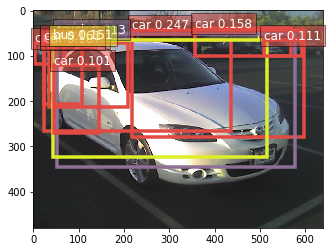

{'car': 0.10109506547451019, 'truck': 0.21292231976985931, 'bus': 0.15109805762767792}
Image Name test-image.jpg
Result: label - Damage, probability - 0.999765932559967
No Audit Needed, execute workflow to create report


In [79]:
url_not_damaged = 'https://upload.wikimedia.org/wikipedia/en/2/2d/Front_left_of_car.jpg'
determine_if_needs_audit_or_filing(od, cdd, image_url= url_not_damaged)